# Poisson process filtering - PyTorch (Lightning) approach

## Imports

In [151]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("hls")
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

## Constants

In [152]:
MAX_ARRIVALS = 128
BATCH_SIZE = 128

## Process generating

In [153]:
def poisson_proc(lmbda, orig, horiz, rng):
    """
    Generates arrivals of a point Poisson process
    """
    arrivals = []
    t = orig
    while t < horiz:
        t = t - np.log(rng.random()) / lmbda
        arrivals.append(t)
    
    return np.sort(arrivals[:-1])

In [154]:
def trajectory(a, b, mu, beg, end, rng):
    """
    Generates concatenated processes arrivals
    """
    tau = beg + rng.exponential(1/mu)
    while tau > end: # force sampling of tau in (beg, end)
        tau = beg + rng.exponential(1/mu)
    arrivals = np.concatenate((poisson_proc(a, beg, tau, rng),
                               poisson_proc(b, tau, end, rng)))
    arrivals = arrivals[:MAX_ARRIVALS]                                        # trim
    arrivals = np.pad(arrivals, (0, MAX_ARRIVALS-arrivals.size), mode='edge') # pad
    return arrivals, tau

In [155]:
def generate_process(rng):
    """
    Generates an item with random parameters
    """
    a = rng.uniform(low=3, high=7)      # low intensity
    b = rng.uniform(low=8, high=12)     # high intensity
    mu = rng.uniform(low=1/6, high=1/4) # for tau
    beg = rng.exponential(5)
    end = beg + 5 + rng.exponential(5) # assert end > beg
    arrivals, tau = trajectory(a, b, mu, beg, end, rng)
    
    return arrivals, tau, a, b, mu, beg, end

## Seed

In [156]:
# setting the seed for reproducibility
seed = 2022
rng = np.random.default_rng(seed)

## Model

In [157]:
class PoissonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(MAX_ARRIVALS+5, 64)
        self.fc2 = nn.Linear(64+5, 32)
        self.fc3 = nn.Linear(32+5, 16)
        self.fc4 = nn.Linear(16+5, 8)
        self.fc5 = nn.Linear(8+5, 4)
        self.fc6 = nn.Linear(4+5, 2)
        self.fc7 = nn.Linear(2+5, 1)
        self.fc8 = nn.Linear(1+5, 1)

    def forward(self, x):
        params = x[:, MAX_ARRIVALS:]
        y = F.elu(self.fc1(x))                         # size 64
        y = F.elu(self.fc2(torch.cat((y, params), 1))) # size 32
        y = F.elu(self.fc3(torch.cat((y, params), 1))) # size 16
        y = F.elu(self.fc4(torch.cat((y, params), 1))) # size 8
        y = F.elu(self.fc5(torch.cat((y, params), 1))) # size 4
        y = F.elu(self.fc6(torch.cat((y, params), 1))) # size 2
        y = F.elu(self.fc7(torch.cat((y, params), 1))) # size 1        
        return self.fc8(torch.cat((y, params), 1))

In [158]:
class ProcessDataset(Dataset):
    def __init__(self, nb_samples, rng):
        self.X = np.empty((nb_samples, MAX_ARRIVALS+5), dtype=np.float32)
        self.y = np.empty((nb_samples, 1), dtype=np.float32)
        for n in range(nb_samples):
            arrivals, tau, a, b, mu, beg, end = generate_process(rng)
            self.X[n, :MAX_ARRIVALS] = arrivals
            self.X[n, MAX_ARRIVALS:] = (a, b, mu, beg, end)
            self.y[n] = tau

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [159]:
train_data = ProcessDataset(2**15, rng)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)

In [160]:
poisson_model = PoissonModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(poisson_model.parameters(), amsgrad=True, lr=5e-3)

In [161]:
nb_epoch = 10
poisson_model.train()
for epoch in range(1, nb_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        for (data, target) in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            optimizer.zero_grad()
            pred = poisson_model(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=loss.item())

Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 130.40batch/s, loss=2.68]


## Statistical analysis

In [162]:
def repeat_ests(model, n_repeats, seed):
    """
    Repeats estimations of tau
    """
    rng = np.random.default_rng(seed) # for reproducibility
    
    taus_l     = []
    est_taus_l = []
    
    for repeat in tqdm(range(n_repeats)):
        arrivals, tau, a, b, mu, beg, end = generate_process(rng)
        taus_l.append(tau)
        x = np.empty((MAX_ARRIVALS+5,), dtype=np.float32)
        x[:MAX_ARRIVALS] = arrivals
        x[MAX_ARRIVALS:] = (a, b, mu, beg, end)
        with torch.no_grad():
            tau_est = model(torch.Tensor(x.reshape(1, -1))).detach().numpy()[0][0]
        est_taus_l.append(tau_est)
        
    return taus_l, est_taus_l

In [163]:
def stat_summary(taus_l, est_taus_l):
    """
    Prints a summary of the estimator and a bar plot of the errors
    """    
    taus_arr = np.array(taus_l)
    est_taus_arr = np.array(est_taus_l)
    
    error = taus_arr - est_taus_arr
    
    print(f"bias: {np.mean(error):.2f}")
    print(f"sigma: {np.std(error):.2f}")
    
    fig = plt.figure(figsize=(10, 3))
    plt.hist(error, bins=50)
    plt.title(fr"$\tau - \hat{{\tau}}$")
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1652.04it/s]


bias: 0.36
sigma: 1.47


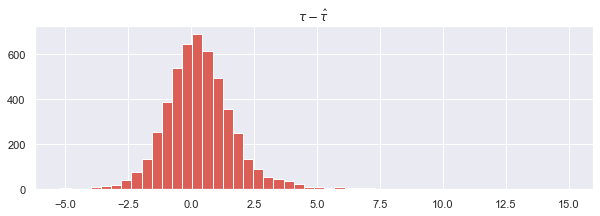

In [164]:
taus_l, est_taus_l = repeat_ests(poisson_model, n_repeats=5000, seed=42)
stat_summary(taus_l, est_taus_l)